In [ ]:
import numpy as np
import pandas as pd
import pickle
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

class NeuralNet:
    def __init__(self, layers, epochs, learning_rate, momentum, activation_function, validation_split):
        self.L = len(layers)
        self.n = layers.copy()
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.fact = activation_function
        self.validation_split = validation_split

        # Initialize arrays for network components
        self.train_errors = []
        self.val_errors = []
        self.h = [np.zeros(n) for n in layers]
        self.xi = [np.zeros(n) for n in layers]
        self.w = [np.zeros((1, 1))] + [np.random.uniform(-1.0, 1.0, (layers[i], layers[i-1])) * np.sqrt(1 / layers[i-1]) for i in range(1, self.L)]
        self.theta = [np.zeros(n) for n in layers]
        self.delta = [np.zeros(n) for n in layers]
        self.d_w = [np.zeros_like(self.w[i]) for i in range(self.L)]
        self.d_theta = [np.zeros_like(self.theta[i]) for i in range(self.L)]
        self.d_w_prev = [np.zeros_like(self.w[i]) for i in range(self.L)]
        self.d_theta_prev = [np.zeros_like(self.theta[i]) for i in range(self.L)]

    def fit(self, X, y):
        n_samples, n_features = X.shape
        # Split data into training and validation sets (80% training, 20% validation)
        split_index = int(n_samples * 0.8)
        X_train, X_val = X[:split_index], X[split_index:]
        y_train, y_val = y[:split_index], y[split_index:]

        for epoch in range(self.epochs):
            for pat in range(len(X_train)):
                # Choose a random pattern from the training set
                idx = np.random.randint(0, len(X_train))
                x_mu, z_mu = X_train[idx], y_train[idx]

                # Forward propagation
                self._forward_propagate(x_mu)

                # Backpropagation
                self._back_propagate(z_mu)

                # Update weights and thresholds
                self._update_weights()

            # Calculate training and validation error
            train_error = self._calculate_error(X_train, y_train)
            val_error = self._calculate_error(X_val, y_val)
            self.train_errors.append(train_error)
            self.val_errors.append(val_error)
            print(f"Epoch {epoch+1}/{self.epochs}, Training Error: {train_error}, Validation Error: {val_error}")

    def predict(self, X):
        n_samples, n_features = X.shape
        y_pred = np.zeros(n_samples)
        for i in range(n_samples):
            self._forward_propagate(X[i])
            y_pred[i] = self.xi[-1]  # Output layer activation
        return y_pred

    def loss_epochs(self):
        training_error = np.zeros(self.epochs)
        validation_error = np.zeros(self.epochs)
        # Track and return training and validation error evolution per epoch
        return training_error, validation_error

    def _forward_propagate(self, x):
        # Set input layer activations
        self.xi[0] = np.array(x, dtype=float)
        # Propagate through layers
        for l in range(1, self.L):
            self.h[l] = np.dot(self.w[l], self.xi[l-1]) - self.theta[l]
            self.xi[l] = self._activation(self.h[l])

    def _back_propagate(self, z):
        # Compute output layer error
        self.delta[-1] = (self.xi[-1] - z) * self._activation_derivative(self.h[-1])
        # Propagate error backwards through hidden layers
        for l in range(self.L-2, 0, -1):
            self.delta[l] = np.dot(self.w[l+1].T, self.delta[l+1]) * self._activation_derivative(self.h[l])

    def _update_weights(self):
        # Update weights and thresholds using gradient descent with momentum
        for l in range(1, self.L):
            self.d_w[l] = -self.learning_rate * np.outer(self.delta[l], self.xi[l-1]) + self.momentum * self.d_w_prev[l]
            self.d_theta[l] = -self.learning_rate * self.delta[l] + self.momentum * self.d_theta_prev[l]
            self.w[l] += self.d_w[l]
            self.theta[l] += self.d_theta[l]
            self.d_w_prev[l] = self.d_w[l]
            self.d_theta_prev[l] = self.d_theta[l]

    def _activation(self, x):
        if self.fact == 'sigmoid':
            return 1 / (1 + np.exp(-np.clip(x, -500, 500)))  # Clip values to prevent overflow
        elif self.fact == 'relu':
            return np.maximum(0, x)
        elif self.fact == 'linear':
            return x
        elif self.fact == 'tanh':
            return np.tanh(np.clip(x, -500, 500))  # Clip values to prevent overflow
        else:
            raise ValueError("Unsupported activation function")

    def _activation_derivative(self, x):
        if self.fact == 'sigmoid':
            sig = 1 / (1 + np.exp(-np.clip(x, -500, 500)))
            return sig * (1 - sig)
        elif self.fact == 'relu':
            return np.where(x > 0, 1, 0)
        elif self.fact == 'linear':
            return np.ones_like(x)
        elif self.fact == 'tanh':
            return 1 - np.tanh(np.clip(x, -500, 500)) ** 2
        else:
            raise ValueError("Unsupported activation function")

    def _calculate_error(self, X, y):
        total_error = 0
        for i in range(len(X)):
            self._forward_propagate(X[i])
            total_error += 0.5 * np.sum((self.xi[-1] - y[i]) ** 2)
        return total_error / len(X)

def evaluate(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mse, mae, mape

# Load training data from CSV file
train_data = pd.read_csv('train_data.csv')

# Convert categorical features to dummy variables
train_data = pd.get_dummies(train_data)

# Separate features and target variable
X = train_data.drop(columns=['CO2 Emissions(g/km)']).values
y = train_data['CO2 Emissions(g/km)'].values


layers = [X.shape[1], 9, 5, 1]  # Network architecture: input layer size based on data, 9 and 5 hidden, 1 output
learning_rate = 0.05
momentum = 0.95
activation_function = 'sigmoid'
epochs = 15

# Initialize and train the model
neural_net = NeuralNet(layers, epochs=epochs, learning_rate=learning_rate, momentum=momentum, activation_function=activation_function, validation_split=0.2)
neural_net.fit(X, y)

# Save evaluation metrics
train_error = neural_net._calculate_error(X, y)
mse, mae, mape = evaluate(y, neural_net.predict(X))
hyperparameter_results = []
hyperparameter_results.append({
    'Number of layers': len(layers),
    'Layer Structure': layers,
    'Num epochs': epochs,
    'Learning Rate': learning_rate,
    'Momentum': momentum,
    'Activation function': activation_function,
    'Training Error': train_error,
    'MSE': mse,
    'MAE': mae,
    'MAPE': mape
})

# Convert results to DataFrame
results_df = pd.DataFrame(hyperparameter_results)
print(results_df)

# Save the trained model
with open('neural_net_model.pkl', 'wb') as file:
    pickle.dump(neural_net, file)
print("Model saved successfully.")

print("L =", neural_net.L)
print("n =", neural_net.n)
print("Weights for layer 2:", neural_net.w[2])


Epoch 1/15, Training Error: 0.0005738237956673587, Validation Error: 0.0006961768081745356
Epoch 2/15, Training Error: 0.00022995081137686512, Validation Error: 0.0003144678904566228
Epoch 3/15, Training Error: 0.00014997111021192034, Validation Error: 0.00021816093738065637
Epoch 4/15, Training Error: 0.00011625329726797881, Validation Error: 0.0001794267028982811
Epoch 5/15, Training Error: 9.820841510841859e-05, Validation Error: 0.00016506277536848814
Epoch 6/15, Training Error: 9.457294621131701e-05, Validation Error: 0.00015996863157783134
Epoch 7/15, Training Error: 8.03816767948221e-05, Validation Error: 0.00014042415963556046
Epoch 8/15, Training Error: 7.18165709353842e-05, Validation Error: 0.000130071393472029
Epoch 9/15, Training Error: 6.666150984423923e-05, Validation Error: 0.00012648094764596056
Epoch 10/15, Training Error: 6.502397841071425e-05, Validation Error: 0.00012531109392438695
Epoch 11/15, Training Error: 6.28899235858738e-05, Validation Error: 0.000117364020

<ipython-input-4-fc94ac77a5a7>:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred[i] = self.xi[-1]  # Output layer activation


   Number of layers  Layer Structure  Num epochs  Learning Rate  Momentum  \
0                 4  [2016, 9, 5, 1]          15           0.05      0.95   

  Activation function  Training Error      MSE       MAE  MAPE  
0             sigmoid        0.000055  0.00011  0.005951   inf  
Model saved successfully.
L = 4
n = [2016, 9, 5, 1]
Weights for layer 2: [[-4.34014641e-01 -9.37383768e-01 -1.17958937e+00 -2.68922778e-01
  -1.20758403e+00  9.36181929e-01 -1.39249058e+00  1.17450644e+00
   1.25217399e+00]
 [ 3.53281855e-01  2.95411888e-01  1.57777416e-01 -4.48663916e-01
   3.82713997e-01 -8.71001184e-01  5.96515300e-01 -9.82164496e-01
  -1.04634732e+00]
 [-3.95166014e-02  7.38745686e-02  3.13589326e-01  3.89958448e-01
  -8.91733440e-02  6.83306033e-01  1.92828422e-01  3.87786510e-01
   1.00890564e-01]
 [ 1.39170933e-03  1.52208779e-01  2.00844344e-01 -1.79066576e-01
   4.68197742e-01 -5.94373958e-01  4.28683869e-01 -1.09261955e+00
  -8.33514304e-01]
 [ 1.40719513e-01 -3.04963675e-01  1.9

<ipython-input-4-fc94ac77a5a7>:134: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100


Model loaded successfully.


<ipython-input-4-fc94ac77a5a7>:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred[i] = self.xi[-1]  # Output layer activation


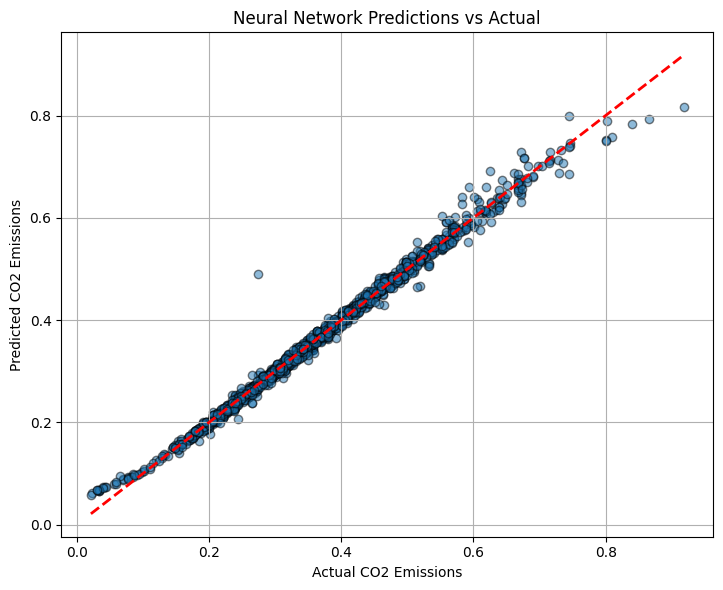

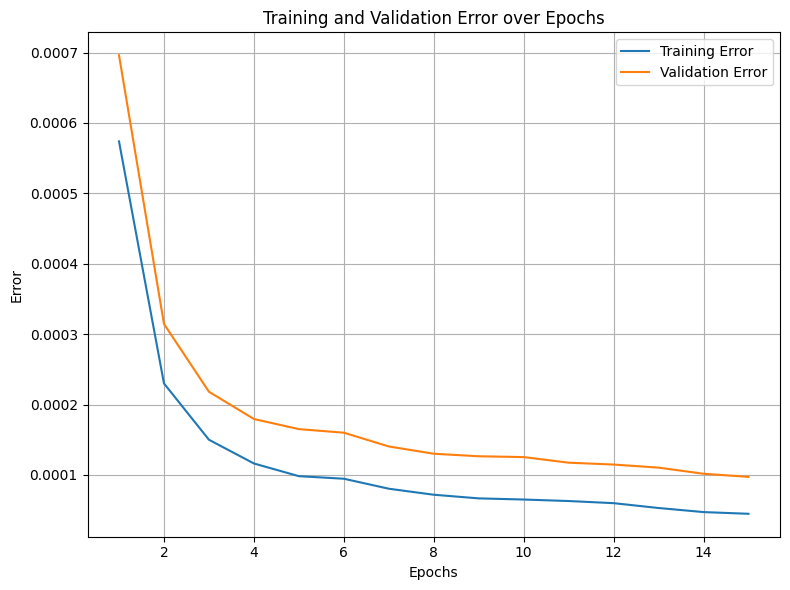

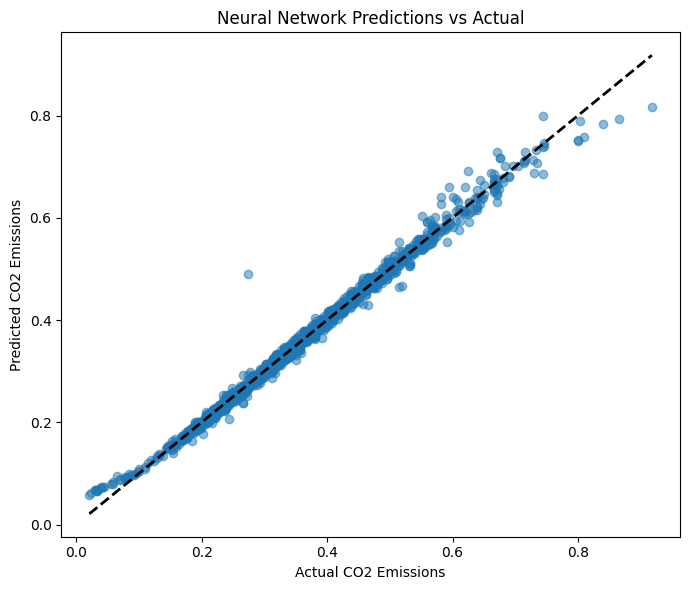

Neural Network - MSE: 0.00015906699625204256, MAE: 0.007490803925757787, MAPE: 3.0516618468930177


In [ ]:
import numpy as np
import pandas as pd
import pickle
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Store columns of training data to apply to test data
train_columns = train_data.columns
test_data = pd.read_csv('test_data.csv')

# Convert categorical features to dummy variables
test_data = pd.get_dummies(test_data)

# Align test data with training data columns to ensure matching feature set
test_data = test_data.reindex(columns=train_columns, fill_value=0)

# Separate features and target variable for test data
X_test = test_data.drop(columns=['CO2 Emissions(g/km)']).values
y_test = test_data['CO2 Emissions(g/km)'].values

# Check if model exists
try:
    with open('neural_net_model.pkl', 'rb') as file:
        neural_net = pickle.load(file)
    print("Model loaded successfully.")
except FileNotFoundError:
    print("Training the model...")
    neural_net.fit(X, y)
    with open('neural_net_model.pkl', 'wb') as file:
        pickle.dump(neural_net, file)
    print("Model saved successfully.")

# Make predictions with neural network
nn_predictions = neural_net.predict(X_test)

# Evaluation metrics
# Generate scatter plots for representative rows
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.scatter(y_test, nn_predictions, alpha=0.5, edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual CO2 Emissions')
plt.ylabel('Predicted CO2 Emissions')
plt.title('Neural Network Predictions vs Actual')
plt.grid(True)
plt.tight_layout()
plt.show()

# Generate error evolution plot
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(neural_net.train_errors) + 1), neural_net.train_errors, label='Training Error')
plt.plot(range(1, len(neural_net.val_errors) + 1), neural_net.val_errors, label='Validation Error')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.title('Training and Validation Error over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
def evaluate(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mse, mae, mape

# Scatter plot
plt.figure(figsize=(7, 6))
plt.scatter(y_test, nn_predictions, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual CO2 Emissions')
plt.ylabel('Predicted CO2 Emissions')
plt.title('Neural Network Predictions vs Actual')
plt.tight_layout()
plt.show()

nn_mse, nn_mae, nn_mape = evaluate(y_test, nn_predictions)

print(f"Neural Network - MSE: {nn_mse}, MAE: {nn_mae}, MAPE: {nn_mape}")


MLR-F - MSE: 4.497926013560522e+18, MAE: 397632169.58094627, MAPE: 144428313532.63803


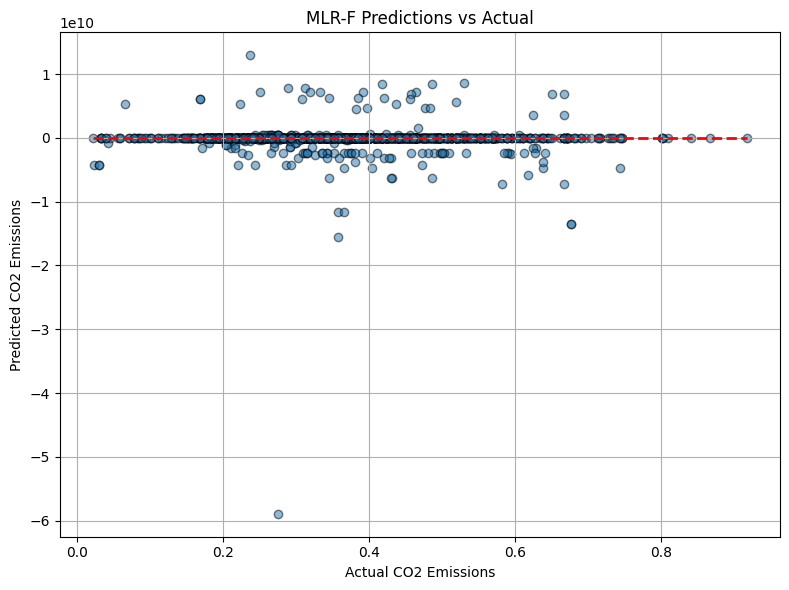

In [ ]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Train the MLR-F model
mlr_model = LinearRegression()
mlr_model.fit(X, y)

# Make predictions using the test data
mlr_predictions = mlr_model.predict(X_test)

# Evaluate the model using MSE, MAE, and MAPE
mlr_mse, mlr_mae, mlr_mape = evaluate(y_test, mlr_predictions)

# Print the evaluation metrics
print(f"MLR-F - MSE: {mlr_mse}, MAE: {mlr_mae}, MAPE: {mlr_mape}")

plt.figure(figsize=(8, 6))
plt.scatter(y_test, mlr_predictions, alpha=0.5, edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual CO2 Emissions')
plt.ylabel('Predicted CO2 Emissions')
plt.title('MLR-F Predictions vs Actual')
plt.grid(True)
plt.tight_layout()
plt.show()


Epoch 1/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0550 - mae: 0.1759 - val_loss: 0.0042 - val_mae: 0.0471
Epoch 2/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0026 - mae: 0.0379 - val_loss: 0.0018 - val_mae: 0.0295
Epoch 3/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.5614e-04 - mae: 0.0224 - val_loss: 0.0011 - val_mae: 0.0224
Epoch 4/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.6215e-04 - mae: 0.0153 - val_loss: 9.0024e-04 - val_mae: 0.0198
Epoch 5/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.2404e-04 - mae: 0.0126 - val_loss: 7.6079e-04 - val_mae: 0.0180
Epoch 6/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.5177e-04 - mae: 0.0111 - val_loss: 6.9297e-04 - val_mae: 0.0170
Epoch 7/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.8794e-04 - mae: 0.0099 - val_loss: 6.3170e-04 - val_mae: 0.0162
Epoch 8/30
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.6637e-04 - mae: 0.0093 - val_loss: 5.9402e-04 - val_mae: 0.0156
Epoch 9/30
1

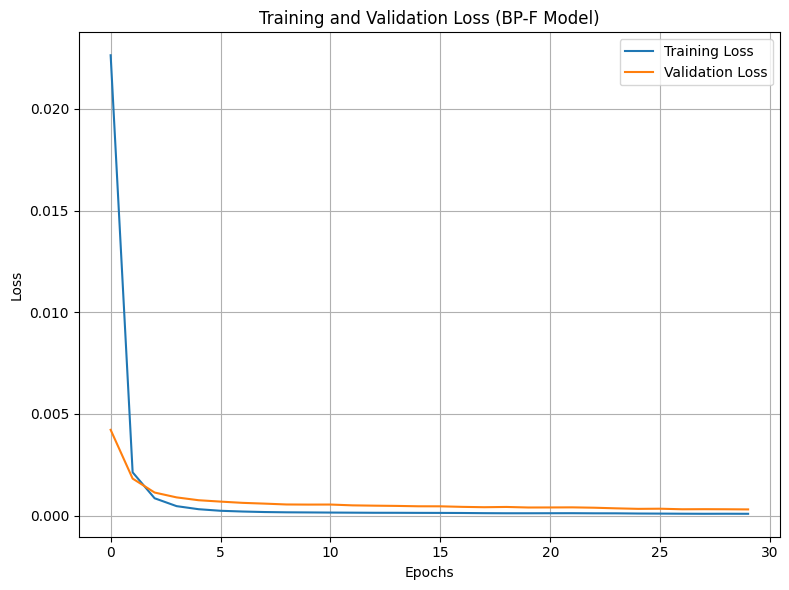

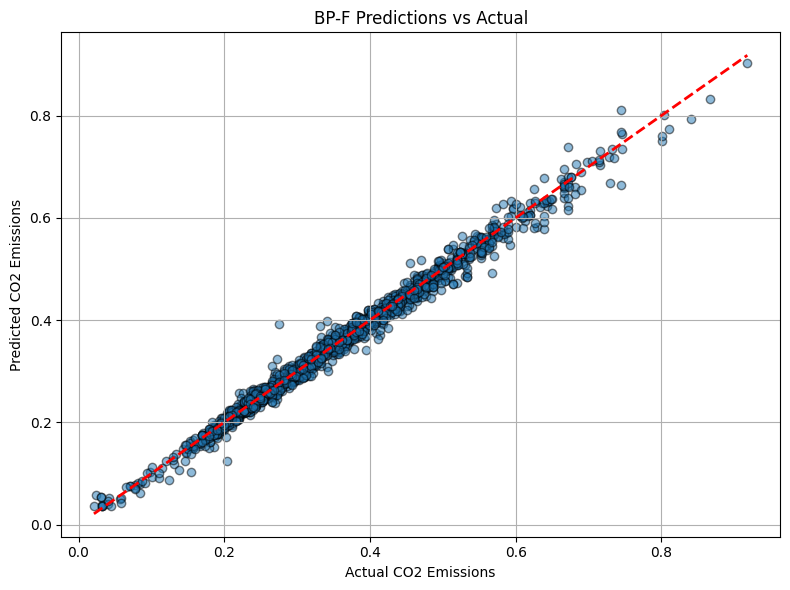

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
import numpy as np
import matplotlib.pyplot as plt

X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.float32)

X_test = np.array(X_test, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)

# Create the BP-F model
tf_model = Sequential([
    Input(shape=(X.shape[1],)),
    Dense(9, activation='relu'),
    Dense(5, activation='relu'),
    Dense(1, activation='linear')
])

# Compile the model
tf_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = tf_model.fit(X, y, epochs=30, batch_size=32, validation_split=0.2, verbose=1)

# Make predictions
bp_f_predictions = tf_model.predict(X_test).flatten()

# Evaluate the model
bp_f_mse, bp_f_mae = tf_model.evaluate(X_test, y_test, verbose=0)
bp_f_mape = np.mean(np.abs((y_test - bp_f_predictions) / y_test)) * 100

print(f"BP-F Neural Network - MSE: {bp_f_mse}, MAE: {bp_f_mae}, MAPE: {bp_f_mape}")

# Plot training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (BP-F Model)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Scatter plot of predictions vs actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, bp_f_predictions, alpha=0.5, edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual CO2 Emissions')
plt.ylabel('Predicted CO2 Emissions')
plt.title('BP-F Predictions vs Actual')
plt.grid(True)
plt.tight_layout()
plt.show()
